## Neural Network Notebook ##

A first draft of the neural network that will be used for the ECG classification project is described in this notebook.

### Initialization ###

We will train our model  with the help of the TensorFlow framework. If you had not installed TensorFlow yet, you can do it easily with the command pip install --upgrade tensorflow.

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras


### Part 1 : importing the data ###

We start by importing our tests data. 

NOTE : training and testing datas can be in the same directory, we can seperate them directly with tensorflow.

NOTE2 : 
What is batch size ? 
Batch size is the number of samples you put into for each training round.
So for each epoch, you can split your training sets into multiple batches.
For example, I have 1000 images.
If I set my batch size to 1, then for each epoch (training round), my input into the network will be 1 x 1000 images.
If set my batch size to 2, then it will be 2 x 500 images.
Meaning, for each epoch, I will run two rounds, each round using 500 images.
Step is just the learning rate that you use for your optimizer.
Usually, we start with 0.001 or 0.01.

Found 108 files belonging to 6 classes.
Found 36 files belonging to 6 classes.


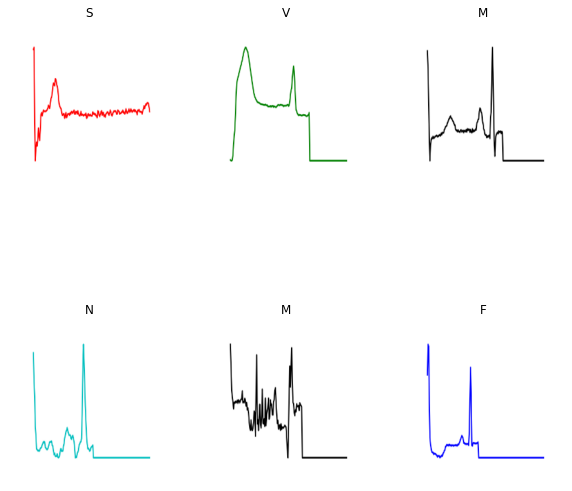

In [70]:
batch_size=1

traindata=tf.keras.utils.image_dataset_from_directory("S_training_datas_labels",labels='inferred',class_names=["F","M","N","Q","S","V"])
valdata=tf.keras.utils.image_dataset_from_directory("S_testing_datas_labels",labels='inferred',class_names=["F","M","N","Q","S","V"])

plt.figure(figsize=(10, 10))
for images, labels in traindata.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(traindata.class_names[labels[i]])
    plt.axis("off")


In [71]:
for image_batch, labels_batch in traindata: 
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


image_bacth shape (32,256,256,3) means a group of 36 images of size 256x256 and the last channel 3 corresponds to the RVB colors reference. 
labels_batch shape (32,) corresponds to the label of the 32 images. 

NOTE : Why 32 ???

### Part 2 : pre-processing the data ###

#### Data standardization ###

For now, RVB channels are in [0,255] which is too large for a neural network. We will then normalize these values. 

NOTE : use only one channel for black and white pictures ???

NOTE 2 :  Rescaling the image can be directly implemented in the model by layer.Rescaling

In [72]:
normalization_layer= tf.keras.layers.Rescaling(1./255)

normtraindata=traindata.map(lambda x, y: (normalization_layer(x),y))

### Part 3 :  creating the model ###

In this part, we define important elements that will be used to build our model. 

NOTE : This model is the one used in the Image Classification tutorial from TensorFlow website, same for the compiler. NEED TO BE RETHINKED AND DISCUSSED. 

In [73]:
# Model Creation

model= keras.Sequential([
    keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(6)
])

model.build((None,256,256,3))

#Model Compiler
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Model summary 
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 32, 32, 64)      

### Part 3 : training and testing ###

Note : This code is taken from the TensorFlow tutorial page. 

Epoch 1/50
4/4 [==============================] - 7s 1s/step - loss: 4.7446 - accuracy: 0.2315 - val_loss: 438.2775 - val_accuracy: 0.1667
Epoch 2/50
4/4 [==============================] - 5s 1s/step - loss: 1.9145 - accuracy: 0.2130 - val_loss: 21.4986 - val_accuracy: 0.4444
Epoch 3/50
4/4 [==============================] - 5s 1s/step - loss: 1.6180 - accuracy: 0.4074 - val_loss: 30.9437 - val_accuracy: 0.5000
Epoch 4/50
4/4 [==============================] - 5s 1s/step - loss: 1.3421 - accuracy: 0.5833 - val_loss: 114.9012 - val_accuracy: 0.4722
Epoch 5/50
4/4 [==============================] - 5s 1s/step - loss: 1.0605 - accuracy: 0.5926 - val_loss: 43.3842 - val_accuracy: 0.6667
Epoch 6/50
4/4 [==============================] - 5s 1s/step - loss: 0.6457 - accuracy: 0.8889 - val_loss: 43.8516 - val_accuracy: 0.7500
Epoch 7/50
4/4 [==============================] - 5s 1s/step - loss: 0.2895 - accuracy: 0.9722 - val_loss: 85.5940 - val_accuracy: 0.8611
Epoch 8/50
4/4 [================

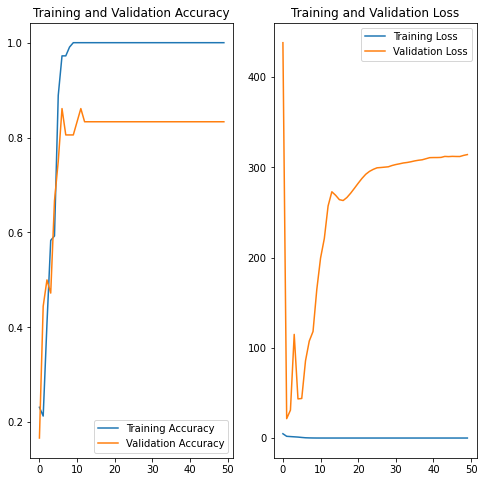

In [74]:
epochs= 50
history = model.fit(
  normtraindata,
  validation_data=valdata,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



### Part 4 : Testing a random image on the model ###

Very simple code to quickly test some predictions on our model. Has to be improved. 

In [75]:
predata=tf.keras.utils.image_dataset_from_directory("S_prediction_datas_labels")

dict={0:"F",1:"M",2:"N",3:"N",4:"Q",5:"S",6:"V"}
prediction = model.predict(predata) 

classes = np.argmax(prediction, axis = 1)

for i,clas in enumerate(classes) :
    print(f"Image {i} is disease "+dict[clas] )
    




Found 6 files belonging to 6 classes.
1/1 [==============================] - 0s 239ms/step
Image 0 is disease N
Image 1 is disease N
Image 2 is disease F
Image 3 is disease N
Image 4 is disease Q
Image 5 is disease M
